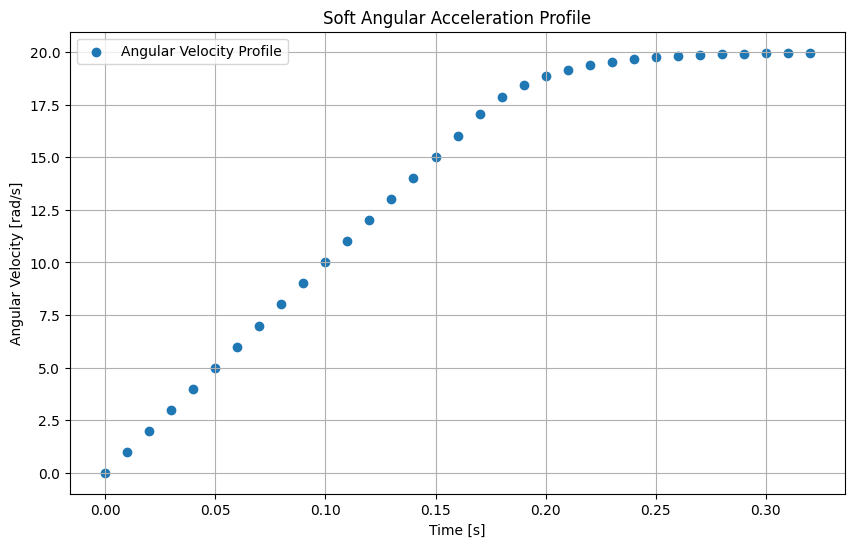

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from typing import Union
class BaseController(ABC):
    @abstractmethod
    def get_control_setpoint(self, current_time_seconds: float) -> Union[float, None]:
        """Abstract method to be implemented by all controller profiles."""
        pass

class SoftAngAccelProfile(BaseController):
    def __init__(self, sim_dt: float, a: float = 100.0, k: float = 5, t0: float = 0.0, t0_t1: float = 0.2, t1_t2: float = 0.2):
        """
        Soft angular acceleration profile w(t) defined as follows:
        for t0 < t < t1*0.8:    w(t) = a*t
        for t1*0.8 < t < 0.8*t2: w(t) smoothly transitions to a*t1.
        for t > t2:             w(t) = <return None>

        Args:
        - sim_dt: Simulation time-discretization in seconds.
        - a: Angular acceleration in rad/s^2.
        - k: Gain for how fast to converge to the constant angular velocity. Higher values = faster convergence
        - t0: Start time for acceleration in seconds.
        - t0_t1: Time duration for acceleration in seconds (mathematically: t1-t0).
        - t1_t2: Time for constant angular velocity in seconds (mathematically: t2-t1).
        """
        self.sim_dt = sim_dt
        self.acceleration = a
        self.k = k
        self.t0 = t0
        self.t1 = t0 + t0_t1
        self.t2 = self.t1 + t1_t2
        self.t1_08 = 0.8 * self.t1  # 0.8 * t1
        self.t2_08 = 0.4 * self.t2  # 0.8 * t2
        self._last_value = 0.0

    def get_control_setpoint(self, current_time_seconds: float) -> Union[float, None]:
        # If current time is less than t0, return None
        if current_time_seconds < self.t0:
            return None

        # Linear acceleration phase: t0 < t < 0.8 * t1
        elif current_time_seconds < self.t1_08:
            self._last_value = self.acceleration * current_time_seconds
            return self._last_value

        # Smooth transition phase: 0.8 * t1 < t < 0.8 * t2
        elif current_time_seconds < self.t2_08:
            # Fraction to track progress between 0.8 * t1 and 0.8 * t2
            fraction = (current_time_seconds - self.t1_08) / (self.t2_08 - self.t1_08)
            # Smooth transition using exponential decay
            difference_to_setpoint = self.acceleration * self.t1 - self._last_value
            return self._last_value + difference_to_setpoint * (1 - np.exp(-self.k * fraction))

        # After t2: return None
        else:
            return None

def plot_soft_ang_accel_profile(sim_dt: float, a: float = 100.0, k: float = 5, t0: float = 0.0, t0_t1: float = 0.2, t1_t2: float = 0.2):
    # Instantiate the SoftAngAccelProfile class
    profile = SoftAngAccelProfile(sim_dt, a, k, t0, t0_t1, t1_t2)
    
    # Generate time values from t0 to t2 with step size sim_dt
    time_values = np.arange(t0, profile.t2 + sim_dt, sim_dt)
    
    # Compute control setpoints for each time value
    control_setpoints = [profile.get_control_setpoint(t) for t in time_values]
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(time_values, control_setpoints, label='Angular Velocity Profile')
    plt.xlabel('Time [s]')
    plt.ylabel('Angular Velocity [rad/s]')
    plt.title('Soft Angular Acceleration Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_soft_ang_accel_profile(sim_dt=0.01)